# Python実証分析入門<a id='top'></a>

###  目次
1. [単回帰分析](#sec1)
    1. [リサーチクエスチョン](#sec1_1)
    2. [ヒストグラム](#sec1_2)
    3. [散布図](#sec1_3)
    4. [単回帰分析](#sec1_4)
    5. [分析結果](#sec1_5)
    6. [summaryレポート詳細](#sec1_6)
    7. [実践1](#sec1_7)
2. [重回帰分析](#sec2)
    1. [実践2](#sec2_1)
3. [予測(機械学習)](#sec3)
4. [検定](#sec4)
    1. [実践3](#sec4_1)
5. [付録：代表的な確率分布](#sec7)
6. [付録１：Numpy計算](#sec8)
7. [付録２：Numpy統計量](#sec9)

先程勉強した回帰分析を、早速Pythonで実装してみます！

In [63]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols  # 回帰分析のパッケージ
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from see import see  # 属性を調べるパッケージ
import plotly.express as px
import seaborn as sns
from scipy import stats
sns.set()
from IPython.display import Image

#!pip install japanize-matplotlib
import japanize_matplotlib  #グラフの名前を日本語で表示するライブラリ

**単回帰分析**  <a id='sec1'></a>  
[先頭に戻る](#top)  

**単回帰分析**  
前半の復習  
$Y_i = \alpha + \beta{X_i}+ u_i$  
$\Leftrightarrow{u_i} = Y_i - \alpha - \beta{X_i}$  
すべてのデータをなるべく直線に当てはめるために、誤差$u_i$の総和を最小にする$\alpha$と$\beta$を求めることが必要であった。  
その代表的な方法が、誤差の二乗和を最小にする$\alpha$と$\beta$を求める、**最小二乗法(OLS:Ordinary least squares)**でした。  
$J=\Sigma{u_i}^2 = \Sigma(Y_i - \alpha - \beta{X_i})^2$

$J$を$\alpha$,$\beta$で偏微分して得られた以下の正規方程式を解いて、  

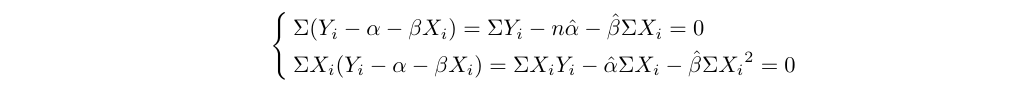

In [64]:
Image("seikihouteisiki.png")

$\alpha$と$\beta$の推定量を得ました。

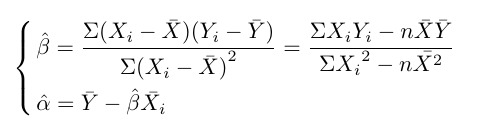

In [65]:
Image('alpha_beta_estimater.png')

最小二乗法の仮定
1. 線形モデルとして書ける
2. 説明変数$X$が散らばっている
3. 標本$(x_i,y_i)$は無作為抽出
4. 誤差項$u_i$は説明変数$x_i$と相関しない
5. 誤差項は互いに独立 $E(u_i,u_j) , \forall i \neq j$
6. 誤差項の分散は均一 $V(u_i|x_i)=E(u_iu_i|x_i)=\sigma^2$
7. (小標本の場合)誤差分布の正規性 $u_i \sim N$

具体例を挙げます。鉄には熱によって膨張するという性質(熱膨張)が備わっています。  鉄道会社に勤めるAさんは、気温と熱の関係を調べる仕事を任されました。そこで、資料を確認すると、下の図と散布図が載っていました。

   heat  length
0    10    1001
1    15    1005
2    20    1007
3    25    1007
4    30    1012


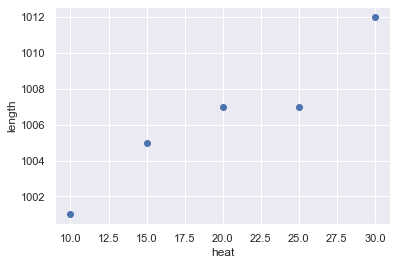

In [66]:
list = [[10,1001],[15,1005],[20,1007],[25,1007],[30,1012]]
df_iron = pd.DataFrame(list)
df_iron.columns=['heat', 'length']
print(df_iron)
plt.plot(df_iron['heat'],df_iron['length'],"o")
plt.xlabel("heat")
plt.ylabel("length")
plt.grid(True)
pass

In [91]:
#上の散布図に線を引くと。
px.scatter(df_iron,x=df_iron['heat'],y=df_iron['length'],trendline='ols')

回帰直線と観測された値の差が残差で、それを最小にするような直線を探す方法が最小二乗法でした。

ここからは、実際のデータを用いてビールの消費量と気候の関係性を分析します。  
#### RQ：気温は、ビールの消費量に影響を与える。  <a id='sec1_1'></a>   
RQ(Research Question)  
$Y = \hat{\alpha} + \hat{\beta}X + \hat{u}$  
$Y$:ビールの消費量,$X$:都道府県別平均気温

必要なエクセルデータはgithubにあげていますので、下のURLからダウンロードください。　　
https://github.com/soleildatadojo/Python-/tree/Python%E5%AE%9F%E8%A8%BC%E5%88%86%E6%9E%90%E5%85%A5%E9%96%80

In [69]:
df = pd.read_csv('beer.csv').drop("Unnamed: 0",axis=1)
df

,prefecture,beer,adult,per_beer,ave_temp
0,北海道,113097000,4509363,25.080483,9.5
1,青森,23177000,1103183,21.009207,11.0
2,岩手,24879000,1059293,23.486420,11.0
3,宮城,43152000,1915548,22.527235,13.6
4,秋田,19229000,868937,22.129337,12.3
5,山形,19776000,924199,21.397989,12.6
6,福島,34195000,1595503,21.432113,14.2
7,茨城,42922000,2443898,17.562926,15.3
8,栃木,30745000,1642620,18.717050,15.2
9,群馬,29684000,1646104,18.032882,16.1


### ヒストグラム <a id='sec1_2'></a>  
[先頭に戻る](#top)

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 19968 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 20154 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 24403 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 12383 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 12426 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 12499 missing from current font.

C:\Users\shinj\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 12540 missing from current font.

C:\Users\shinj\anaco

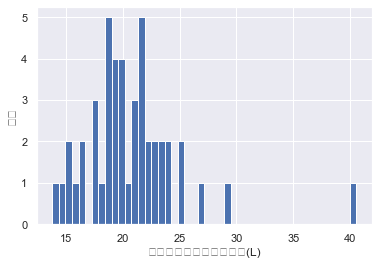

In [70]:
#ビールの消費量を、ヒストグラムで出力する。
plt.hist(df["per_beer"],bins = 46,ec = "white")
plt.xlabel("一人当たりビール消費量(L)")
plt.ylabel("頻度")
plt.show()
pass

In [71]:
#ビール消費量のヒストグラムをplotlyで出力する。
hist = px.histogram(df,x=df["per_beer"],nbins=46,labels={'count':'頻度','per_beer':'一人当たりビール消費量'})
hist

### 散布図  <a id='sec1_3'></a>  
[先頭に戻る](#top)

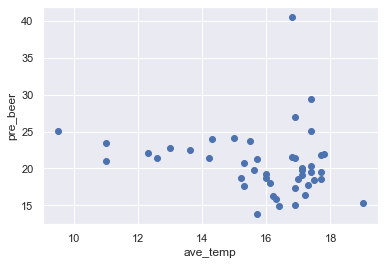

In [72]:
#散布図を描くための下準備
%matplotlib inline
import matplotlib.pyplot as plt

#図に使う変数の設定
plt.plot(df['ave_temp'],df['per_beer'],"o")

#軸の名前を設定
plt.xlabel("ave_temp")
plt.ylabel("pre_beer")
#メモリを入れる
plt.grid(True)
pass

In [73]:
#ビール消費量と平均気温の散布図をplotlyで出力する。
scatter = px.scatter(df,x=df['ave_temp'],y=df['per_beer'],trendline='ols', title='ビール消費量と平均気温',labels={'ave_temp':'平均気温', 'per_beer':'ビール消費量'})
scatter

### 単回帰分析  <a id='sec1_4'></a>  
[先頭に戻る](#top)

In [74]:
y,x = df['per_beer'],df['ave_temp']

#statsmodelsを用いて回帰分析する。
formula = 'y ~ x'
mod = ols(formula, data=df)#ols 最小二乗法
res = ols(formula, data=df).fit()

In [75]:
#得られた関数の係数を把握。
res.params

Intercept    27.378108
x            -0.422595
dtype: float64

$Y = \hat{\alpha} + \hat{\beta}X + \hat{u}$より、  
$Y = 27.3781 + -0.4226X + u$  
であることがわかる。次により詳しい統計量を調査する。

### 分析結果  <a id='sec1_5'></a>  
[先頭に戻る](#top)

In [76]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.735
Date:                Sat, 20 Mar 2021   Prob (F-statistic):              0.195
Time:                        12:46:19   Log-Likelihood:                -132.09
No. Observations:                  46   AIC:                             268.2
Df Residuals:                      44   BIC:                             271.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3781      5.131      5.336      0.000      17.038      37.719
x             -0.4226      0.321     -1.317      0.195      -1.069       0.224
==============================================================================
Omnibus:                       44.781   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.410
Skew:                           2.395   Prob(JB):                     1.84e-44
Kurtosis:                      12.063   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

この中でも特に重要なのが、R-squared:決定係数 です。式を復習します。

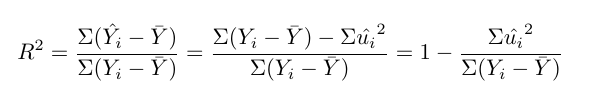

In [77]:
Image("R_squered.png")

決定係数は０から１の値を取り、１に近づくほどモデルの当てはまりが良いことを表す指標です。今回の分析結果では決定係数が0.038と非常に低い値になっています。この要因としては、そもそもXがYを説明できていないことや、共変量が考量できていない可能性があります。  

Q1:ここでいくつか共変量として考えられる変数を考え、改善したモデルを設計してみましょう。

C:\Users\shinj\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='ave_temp', ylabel='per_beer'>

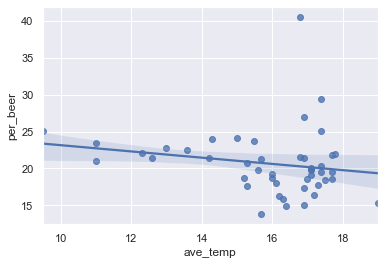

In [78]:
#seabornで95％信頼区間を表示した回帰直線を記述する。
import seaborn as sns
sns.regplot(x,y,data=df,x_ci='95')

### summaryレポート詳細  <a id='sec1_6'></a>  
[先頭に戻る](#top)

このsummaryレポート詳しい見方を３つに分けて検討します。

In [79]:
#上段
res.summary().tables[0]

Dep. Variable:,y,R-squared:,0.038
Model:,OLS,Adj. R-squared:,0.016
Method:,Least Squares,F-statistic:,1.735
Date:,"Sat, 20 Mar 2021",Prob (F-statistic):,0.195
Time:,12:46:21,Log-Likelihood:,-132.09
No. Observations:,46,AIC:,268.2
Df Residuals:,44,BIC:,271.8
Df Model:,1,,
Covariance Type:,nonrobust,,


- Dep.Variable:被説明変数の名前、Dep(=Depended(従属変数))  
- Model:使用したモデル  
- Date:コード実行時の時間  
- No.Observations:サンプルサイズ  
- Df Residuals:サンプルサイズ数から、推定されたパラメータ数を引いたもの  
- Df Model:使用した説明変数の数  
- Covariance Type:共分散の種類。指定しなければnonrobustを返す。  
- R-Squared・Adj,R-Squared:決定係数と自由度調整済み決定係数。  
- F-statistics・Prob(F-statistics):分散分析結果  
- Log-Likelihood:最大対数尤度  
- AIC:赤池情報量基準  
- BIC:ベイズ情報量基準

In [80]:
#中段
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,27.3781,5.131,5.336,0.000,17.038,37.719
x,-0.4226,0.321,-1.317,0.195,-1.069,0.224


- coef:係数  
- std err:標準誤差  
- t:t値  
- P>|t|:P値  
- [0.025,0.975] :95%信頼区間

中段では変数について詳しい説明があります。  

In [81]:
#下段
res.summary().tables[2]

Omnibus:,44.781,Durbin-Watson:,2.021
Prob(Omnibus):,0.000,Jarque-Bera (JB):,201.410
Skew:,2.395,Prob(JB):,1.84e-44
Kurtosis:,12.063,Cond. No.,128.


- Omnibus：オムニバス統計量
- Prob(Omunibus)：オムニバス統計量のP値
- Skew：歪度、Skew<0:右に寄る,Skew=左右対称,Skew>0:左に寄る
- Kurtosis：尖度、大きいほど尖っている
- Durbin-Watson：ダービン・ワトソン比,時系列データの自己相関の分析
- Jarque-Bera (JB) :ジャック-ベラ検定、
- Prob(JB):ジャック-ベラ検定統計量のP値
- Cond. No.：条件数(Condition number),多重共線性の目安。小さいほど良いとされる。

次に、被説明変数の変化率の増減を分析したい場合や、説明変数の割合が増加したことによる被説明変数への影響を分析したい場合、対数logを用いて分析します。数式にすると、  
$Y = In\hat{\alpha} + In\hat{\beta}X + \hat{u}$  
と書けます。  
ここでは、上の例を使って、平均気温が１％上昇したときに、ビールの消費量がどれほどの割合で増減したか、分析してみます。

In [82]:
#numpyを使って対数を導出
y,x = df['per_beer'],df['ave_temp']

formula_log = 'np.log(y) ~ np.log(x)'
mod_log = ols(formula_log, data=df)
res_log = ols(formula_log, data=df).fit()
res_log.params

Intercept    3.930519
np.log(x)   -0.334184
dtype: float64

$Y = In\hat{\alpha} + In\hat{\beta}X + \hat{u}$より、  
$Y = 3.9305 + -0.3341X + u$  
です。

この結果より、平均気温が1％増加したとき、ビールの消費量は0.334%減少する。という結果が得られました。

In [83]:
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              np.log(y)   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.976
Date:                Sat, 20 Mar 2021   Prob (F-statistic):             0.0915
Time:                        12:46:24   Log-Likelihood:                 12.869
No. Observations:                  46   AIC:                            -21.74
Df Residuals:                      44   BIC:                            -18.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9305      0.534      7.355      0.000       2.854       5.007
np.log(x)     -0.3342      0.194     -1.725      0.092      -0.725       0.056
==============================================================================
Omnibus:                       20.105   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.935
Skew:                           1.193   Prob(JB):                     5.79e-09
Kurtosis:                       6.755   Cond. No.                         60.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 実践１  <a id='sec1_7'></a>  
[先頭に戻る](#top)

ここに、あるお店の売り上げデータがあります。salesは売上金額(万円)、meterは駅からの距離(m)、squareは店の広さ(平米)、competitionは競合店舗の数、sakeは酒類の提供の有無を示すダミー変数です。

In [84]:
task_list = [[72.3,50,40.5,1,0],[58.5,120,66.7,5,1],[43.8,280,42.0,4,0],[64.8,80,81.2,3,0],[45.7,540,70.3,2,1],[61.5,200,52.8,4,1],[55.3,350,88.4,2,1],[31.0,720,55.9,4,1]]
df_task = pd.DataFrame(task_list)
df_task.columns=['sales', 'meter','square','competition','sake']
df_task

,sales,meter,square,competition,sake
0,72.3,50,40.5,1,0
1,58.5,120,66.7,5,1
2,43.8,280,42.0,4,0
3,64.8,80,81.2,3,0
4,45.7,540,70.3,2,1
5,61.5,200,52.8,4,1
6,55.3,350,88.4,2,1
7,31.0,720,55.9,4,1


**このデータを用いて単回帰分析を行い、お店の広さが売り上げに与える影響を分析してみましょう！**

kurtosisとは尖度のことです。データ数が20以上でないと十分な尖度のテストができないので、エラーが表示されています。

## 重回帰分析  <a id='sec2'></a>  
[先頭に戻る](#top)  

In [85]:
import numpy as np
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import seaborn as sns
from see import see
from sklearn.model_selection import train_test_split

ここでは修学年数と性別差が、賃金に与える影響を分析します。

In [86]:
df_income = pd.read_csv("7_1_income.csv")
df_income

,female,yeduc,lincome,female_yeduc
0,0,9,4.605170,0
1,0,9,5.010635,0
2,0,9,4.605170,0
3,0,9,5.010635,0
4,0,9,5.329089,0
...,...,...,...,...
4281,1,18,6.396930,18
4282,1,18,6.396930,18
4283,1,18,6.551080,18
4284,1,18,6.396930,18


ここで、以下のモデルに当てはめてみる。  
$lincome = \beta_0 + \beta_1{yeduc} + \beta_2{female} + U$

In [87]:
#被説明変数と説明変数を追加
formula_income = "lincome ~ yeduc + female"

res_income = ols(formula_income,data = df_income).fit()

#係数の推定値を取得
res_income.params

Intercept    4.863272
yeduc        0.058598
female      -0.832148
dtype: float64

従って、得られた重回帰直線は  
$lincome = 4.8633+ 0.0586{yeduc} -0.8321{female} + U$

In [88]:
res_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lincome   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     605.0
Date:                Sat, 20 Mar 2021   Prob (F-statistic):          3.98e-232
Time:                        12:46:30   Log-Likelihood:                -5265.0
No. Observations:                4286   AIC:                         1.054e+04
Df Residuals:                    4283   BIC:                         1.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8633      0.096     50.593      0.000       4.675       5.052
yeduc          0.0586      0.007      8.696      0.000       0.045       0.072
female        -0.8321      0.025    -32.827      0.000      -0.882      -0.782
==============================================================================
Omnibus:                     1327.704   Durbin-Watson:                   0.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4079.440
Skew:                          -1.594   Prob(JB):                         0.00
Kurtosis:                       6.562   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Q:この表から何が言えるのか、検討してみましょう。**

### 実践2  <a id='sec2_1'></a>  
**df_taskデータを用いて重回帰分析を行ってみましょう。**

In [89]:
df_task

,sales,meter,square,competition,sake
0,72.3,50,40.5,1,0
1,58.5,120,66.7,5,1
2,43.8,280,42.0,4,0
3,64.8,80,81.2,3,0
4,45.7,540,70.3,2,1
5,61.5,200,52.8,4,1
6,55.3,350,88.4,2,1
7,31.0,720,55.9,4,1


重回帰分析キーワード  
- 多重共線性  
多重共線性をはかる指標の一つである、VIF統計量は下で述べます。

## 予測(機械学習)<a id='sec3'></a>  
[先頭に戻る](#top)  

重回帰分析の章で扱った女性のincomeデータを用いて、機械学習モデルで予測をしてみる。

In [40]:
t = df_income["lincome"].values
x = df_income.drop(labels=["lincome","female_yeduc"],axis = 1).values

In [41]:
#テストデータと訓練データの分割
from sklearn.model_selection import train_test_split
x_train,x_test,t_train,t_test = train_test_split(x, t, test_size=0.3,random_state=0)

In [42]:
#件数の確認
#print(len(x_test))
#print(len(x_train))

In [43]:
#アルゴリズムの宣言
from sklearn.linear_model import LinearRegression
model = LinearRegression()

#モデルに使用するデータを当てはめる。
model.fit(x_train,t_train)

LinearRegression()

In [44]:
#訓練データから得られた係数
model.coef_

array([-0.82293669,  0.06667076])

In [45]:
#重回帰分析の章で得た推定値は以下の通りでした。おおよそ似通った値が得られています。
res_income.params

Intercept    4.863272
yeduc        0.058598
female      -0.832148
dtype: float64

In [46]:
#切片が確認できる。
model.intercept_

4.7527226399255955

In [47]:
#決定係数の表示
print(f"train score:{model.score(x_train,t_train)}")
print(f"test score:{model.score(x_test, t_test)}")

train score:0.22382650613186972
test score:0.2109899669650963


決定係数が得られましたが、テストデータの決定係数は訓練データの決定係数には及びませんでした。  
テストデータの予測精度を高めることを目標する分野が機械学習です！  
有名なモデルでは、決定木(ランダムフォレスト)があります。

In [48]:
#それでは、ボストン住宅価格データセットを使ってデータ解析をしてみましょう。
from sklearn.datasets import load_boston
dataset  = load_boston()
x,t = dataset.data,dataset.target
columns = dataset.feature_names
df = pd.DataFrame(x, columns=columns)
df["Target"] = t
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


データの説明（print(dataset.DESCR)）
- CRIM:町ごとの一人当たりの犯罪率
- ZN:25,000平方フィート以上の居住区画の占める割合。
- INDUS:小売業以外の商業が占める面積の割合
- CHAS:チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)
- NOX:窒素酸化物の濃度（自動車やボイラー、工場、家庭暖房などで発生する）
- RM:住居の平均部屋数
- AGE:1940 年より前に建てられた物件の割合
- DIS:5つのボストン市の雇用施設からの距離
- RAD:環状高速道路へのアクセスしやすさ
- TAX:10,000ドルあたりの不動産税率の総計
- PTRATIO:町毎の児童と教師の比率
- B:町毎の黒人の比率
- LSTAT:給与の低い職業に従事する人口の割合 (%)
- MEDV:所有者が占有している家屋の1000ドル単位の中央値

この表の中から、Targetを被説明変数として、予測をしてみましょう。

In [49]:
#.valuesでnumpyに変換
t = df["Target"].values
x = df.drop(labels=["Target"],axis = 1).values

#データセット分割
x_train,x_test,t_train,t_test = train_test_split(x, t, test_size=0.3,random_state=0)

#モデルの宣言
model=LinearRegression()

#モデルに当てはめる
model.fit(x_train,t_train)

LinearRegression()

In [50]:
#係数の値
model.coef_

array([-1.21310401e-01,  4.44664254e-02,  1.13416945e-02,  2.51124642e+00,
       -1.62312529e+01,  3.85906801e+00, -9.98516565e-03, -1.50026956e+00,
        2.42143466e-01, -1.10716124e-02, -1.01775264e+00,  6.81446545e-03,
       -4.86738066e-01])

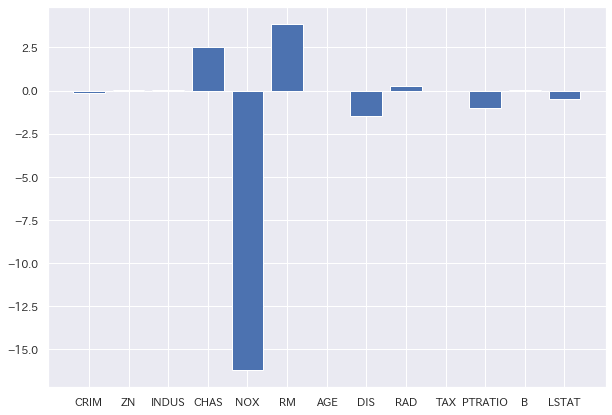

In [51]:
#係数の値をグラフに表示してみる。
plt.figure(figsize=(10,7))
plt.bar(x=columns, height=model.coef_)
pass

In [52]:
#決定係数の表示
print(f"train score:{model.score(x_train,t_train)}")
print(f"test score:{model.score(x_test, t_test)}")

train score:0.7645451026942549
test score:0.6733825506400205


ここまでできましたでしょうか。予測は機械学習の花形です。より高度なモデルを作成してみてください！

- VIF統計量  
多重共線性の疑いを測る指標です。一般にVIF統計量が10以上であれば多重共線性を疑う必要があるとされます。  
以下に簡単にVIF統計量をPythonで導出する方法を記します。

    VIF Factor features
0     2.100373     CRIM
1     2.844013       ZN
2    14.485758    INDUS
3     1.152952     CHAS
4    73.894947      NOX
5    77.948283       RM
6    21.386850      AGE
7    14.699652      DIS
8    15.167725      RAD
9    61.227274      TAX
10   85.029547  PTRATIO
11   20.104943        B
12   11.102025    LSTAT


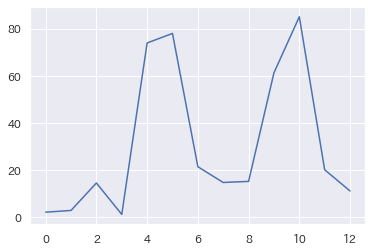

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 標本データを取得
data_x = pd.DataFrame(dataset.data,columns=dataset.feature_names)
 
# 正解データを取得
data_y = pd.DataFrame(dataset.target,columns=['target'])

#vifを計算する
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]
vif["features"] = data_x.columns
 
#vifを計算結果を出力する
print(vif)
 
#vifをグラフ化する
plt.plot(vif["VIF Factor"])
pass

## ｔ検定  <a id='sec4'></a>  
[先頭に戻る](#top)

得られた傾き係数の推定量が統計的に意味のある数字なのか判定するために、仮説検定を行います。

例えば、  
$Y = \beta_0+ \beta_1{X_1} + \beta_2{X_2} + U$(Uは誤差項)  
という回帰式が得られたとしましょう。  
その時、$\beta_1$がYに対して効果がある係数なのかどうか判定します。  
その方法として、「効果がない」という帰無仮説($H_0$)と、それを否定する対立仮説($H_1$)を設定します。    
$H_0:\beta_1=0$  
$H_1:\beta_1 \neq 0$  
今回の例では、以上のように設定できます。  
そして、$H_0$が実現する確率が、ある確率(95％が慣例)より低いかどうかを検定します。

検定のために、仮定を置きます。  
仮定１：説明変数の平均独立  
仮定２：誤差項の正規性（$U \sim N(0,s^2)$）

誤差項の正規性のもとでは、傾きパラメータの最小二乗推定量も正規分布に従うので、  
$\hat{\beta_1} \sim N(\beta_1,v[\hat{\beta_1}])$

これを標準化すると標準正規分布に従う。  
➀誤差項$U_i$の分散が既知の場合。  
➁誤差項$U_i$の分散が未知の場合。  
の二つの状況を考える。

➀誤差項$U_i$の分散が既知の場合。  
$\displaystyle \frac{\hat{\beta_1} - \beta_1}{sd(\hat{\beta_1})} \sim N(0,1)$  

$sd(\hat{\beta_1})$は標準偏差  

➁誤差項$U_i$の分散が未知の場合。  
検定統計量：$t=\displaystyle \frac{\hat{\beta_1} - \beta_1}{se(\hat{\beta_1})} \sim t(n-(k+1))$

$k$は説明変数の数  
標準誤差$se(\hat{\beta_1})$：OLS推定量の分散の平方根を取ったもの。

自由度が30を超える場合、t分布は標準正規分布に近似できます。  
そのため、➀と➁は$n\geqq30$のとき同じ意味を持ちます。

**具体例**

最初に使ったビールのデータを用いて、説明変数の影響を調べるためにt検定を行います。  
ビールの単回帰式は以下のように設定しました。
$Y = \hat{\alpha} + \hat{\beta}X + \hat{u}$  
$Y$:ビールの消費量,$X$:都道府県別平均気温

t検定に際して、帰無仮説と対立仮説を以下のように設定し、95％の有意水準で両側検定を行います。  
$H_0:\beta=0$  
$H_1:\beta \neq 0$  
有意水準95%

In [60]:
res.summary().tables[0]

Dep. Variable:,y,R-squared:,0.038
Model:,OLS,Adj. R-squared:,0.016
Method:,Least Squares,F-statistic:,1.735
Date:,"Sat, 20 Mar 2021",Prob (F-statistic):,0.195
Time:,11:38:42,Log-Likelihood:,-132.09
No. Observations:,46,AIC:,268.2
Df Residuals:,44,BIC:,271.8
Df Model:,1,,
Covariance Type:,nonrobust,,


In [55]:
#中段
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,27.3781,5.131,5.336,0.000,17.038,37.719
x,-0.4226,0.321,-1.317,0.195,-1.069,0.224


➁誤差項$U_i$の分散が未知の場合。
より、  
検定統計量：$t=\displaystyle \frac{\hat{\beta} - \beta}{se(\hat{\beta})} \sim t(n-(k+1))$  
ですので、  
この式に$H_0:\beta=0,n=46,k=1$を代入します。

検定統計量：$t_{\beta}=\displaystyle \frac{\hat{\beta}}{se(\hat{\beta})} \sim t(44)$  
さらに、summaryレポート中段より、coef=-0.4226,std err=0.321なので、t値は  

In [62]:
print("t値:"+str(-0.4226/0.321))

t値:-1.3165109034267912


これは上のsummaryレポートに記載されているt値と一致しています。

t分布表を見ると、自由度44,上側確率0.025の統計検定量$t_{44}$は2.021です。

$|t_{\beta}|=1.316 < t_{44}=2.021$  
なので、$t_{\beta}$は棄却できません。よって、帰無仮説が採択されます。  
従って、$t_{\beta}$は95%の有意水準で効果がないと言えます。

**まとめ**    
#### RQ：気温は、ビールの消費量に影響を与える。    
というRQは95％の有意水準で棄却された。

### 実践3<a id='sec4_1'></a>  
[先頭に戻る](#top)  
df_taskを用いて、t検定をしてみましょう。

### 付録：代表的な確率分布**  <a id='sec7'></a>  
[先頭に戻る](#top)  

**正規分布**<a id='sec4_2'></a>  
$f(x)= \frac{1}{\sqrt{2 \pi \sigma^2}}e^{(-\frac{(x-\mu)}{2 \sigma^2})} =\frac{1}{\sqrt{2 \pi }\sigma}exp{(-\frac{(x-\mu)}{2 \sigma^2})} \sim(\mu,\sigma^2)$  
$E(X)=\mu$  
$V(X)=\sigma^2$  
[先頭に戻る](#top)

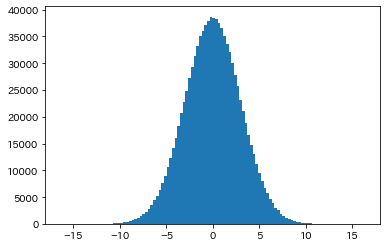

In [196]:
b = np.random.normal(0,3,1000000)
plt.hist(b,bins=100)
plt.xlim(-18,18)
pass

**68–95–99.7rule**  
正規分布において、平均値を中心として、2σ,4σ,6σの幅に入るデータの割合のこと。  
平均値から、  
2σ範囲に入る確率は68.27%  
4σ範囲に入る確率は95.45%  
6σ範囲に入る確率は99.73%  
$P(\mu -\sigma \leq X \leq \mu + \sigma)\fallingdotseq 0.6827$  
$P(\mu -2\sigma \leq X \leq \mu + 2\sigma)\fallingdotseq 0.9545$  
$P(\mu -3\sigma \leq X \leq \mu + 3\sigma)\fallingdotseq 0.9973$  

チェビシェフの不等式  
$x$が平均$\mu$、分散$\sigma^2$の確率変数とするとき、$\lambda$を任意の整数として、  
$P(|X-\mu| \geqq \lambda \sigma) \leqq \frac{1}{\lambda^2}$  
が成立する。(岩田,1983)

この関係を用いれば、$\lambda=3$の時、$P \leqq \frac{1}{9} \fallingdotseq 
0.112$となる。  
これは、88.9％の確率で、確率変数$x$の実現値が6σの範囲に収まるということを意味する。  
この関係式は、確率変数$x$の確率分布に依存せずに成立する！

**標準正規分布**$(\mu =0,\sigma^2=1)$  
$\phi(x)= \frac{1}{\sqrt{2 \pi}}e^{(-\frac{x^2}{2})} \sim (0,1)$

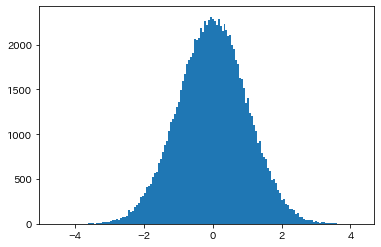

In [197]:
x = np.random.randn(100000)#標準正規分布に従う乱数を100000個生成
np.random.seed(0)
plt.hist(x, bins="auto")#xをヒストグラムにプロットする。ヒストグラムの本数は'auto'
plt.show()#グラフを表示

**t分布**

ｔ分布の特徴  
・形が標準正規分布と似ている。(０を中心に左右対称)  
・標準正規分布よりも散らばりが大きい。(分布の裾が厚い)  
・自由度が高くなると上旬正規分布で近似できる。（自由度３０以上）  

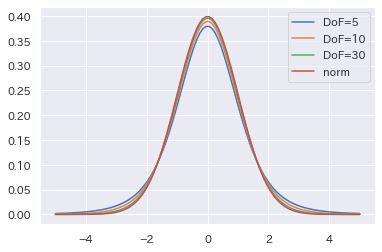

In [83]:
fig = plt.figure()
t_stat = fig.add_subplot(111)
x = np.linspace(-5,5,100)
for t in [5,10,30]:
    t_pdf = stats.t.pdf(x=x, df=t)
    t_stat.plot(x, t_pdf, label='DoF={}'.format(t))
t_stat.plot(x, stats.norm.pdf(x), label='norm')
t_stat.legend(loc='best')
pass
#DoF = Degree of Freedom

**付録１：Numpy計算**  <a id='sec8'></a>  
[先頭に戻る](#top)  

**平方根 $\sqrt{x}$**

In [2]:
np.sqrt(4)

2.0

**eを底とする指数関数 $e^x$, $\exp(x)$**

In [3]:
np.exp(1)

2.718281828459045

**自然対数(底をeとする対数) ($\log_ex, \ln x$)**

In [4]:
np.log(2.718281828459045)

1.0

**常用対数(底を10とする対数)**($\log_{10}x$)

In [5]:
np.log10(10)

1.0

対数の定義：指数と対数の関係  
$a^p = M \Leftrightarrow p = \log_aM$

・ネイピア数(自然対数の底)の定義  
$e = \displaystyle \lim_{x \to \infty}(1 + \frac{1}{n})^n$  
あるいは  
$e = \displaystyle \lim_{h \to 0}(1+h)^\frac{1}{h}$  

・ネイピア数の性質  
指数関数$y = e^x$は微分しても、積分しても、$y = e^x$のままである。

**コラム 日常に潜む対数**  
ベンフォードの法則：世の中に出現する数値の最高位には、1が最も多くあらわれ、1から9になるにつれて出現確率が減少するという法則。  
この法則によると、最高位がkとなるおおよその確率は、常用対数を用いて、
$\log_{10}(1 + \frac{1}{k}) $となることが知られています。  
この法則は会社の帳簿の不正監査に用いられることもあります。

**付録２：Numpy統計量**  <a id='sec9'></a>  
[先頭に戻る](#top)  

統計量とは  
・一般に母集団の特性を表す特性値、代表値を推定するために標本から作られるものを**統計量**とよびます。(大屋,2003)  
・標本の性質を代表して表わす数値を**統計量(statistic)**と呼ぶ。(岩田,1983)

**標本平均** $(\overline{x} = \displaystyle \frac{1}{n}\Sigma_{i=1}^{n}x_i)$  

In [6]:
x = [1,2,3,4,5]
np.mean(x)

3.0

**標本中央値**

In [7]:
np.median(x)

3.0

**標本分散**($S_x^2 = {\displaystyle \frac{1}{n-1}\Sigma_{i=1}^{n}}(x_i-\overline{x})^2$)

In [8]:
np.var(x,ddof=1)

2.5

ちなみに...ddof=Delta Degrees of Freedom  
$S^2 = {\displaystyle \frac{1}{n-ddof}\Sigma_{i=1}^{n}}(x_i-\overline{x})^2$  
pythonは上記のように計算しているので、ddof=1と設定することで不偏分散が得られる。

**標本標準偏差**$(S_x=\sqrt{{\displaystyle \frac{1}{n-1}\Sigma_{i=1}^{n}}(x_i-\overline{x})^2})$

In [9]:
np.std(x,ddof=1)

1.5811388300841898

**標本共分散**($Cov_{xy}={\displaystyle \frac{1}{n-1}\Sigma_{i=1}^{n}}(x_i-\overline{x})(y_i-\overline{y}$))

In [10]:
xy=[[1,2,3,4,5],[2,7,8,5,9]]
np.cov(xy,ddof=1)

array([[2.5, 3. ],
       [3. , 7.7]])

**標本相関係数**$(r_{xy} =\displaystyle \frac{Cov_{xy}}{S_x \cdot S_y})$

In [37]:
np.corrcoef(xy)

array([[1.        , 0.68376346],
       [0.68376346, 1.        ]])

In [ ]:
#DataFrameをcsvにしてダウンロードする関数
from IPython.core.display import display, HTML
def download(df):
    df.to_csv("beer.csv", encoding = 'utf-8')
    display(HTML('<a download="beer.csv" href="beer.csv">Download</a>'))

download(df)